GANs worksheet

This worksheet shows an implementation of GANs.
Pytorch is used to implement the Neural network and backpropagation.
The different lossfunctions are implemented using torch

The goal of this worksheet is to explain how GANs work in very simple applications.

In [296]:
import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn

from tqdm import tqdm

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

The goal of the GAN in this worksheet is to map samples from one distribution to another distribution.
First two distributions are defined. The first is the distribution of the prior:
With probability density function $$P_z(\textbf{z})$$
This distribution is defined as a normal distribution.

The second distribution acts as the real data.
From this distribution samples are taken during the training process.



In [297]:
def noisesample(size,mu=-0.1,sigma=0.01):
    """Generate realizations of the prior noise.
    """
    #return np.random.normal(mu,sigma,size)
    return np.random.uniform(-1,1,size)

def data_distribution(size,mu=0.1,sigma=0.02):
    """Generate realizations from the data distribution.
    This function acts as data generator.
    """
    return np.random.normal(mu,sigma,size)

In [298]:
arraylength = 100
n_input, n_hidden, n_out = arraylength,128,arraylength

Generator = nn.Sequential(nn.Linear(n_input, n_hidden),
                          nn.ReLU(),
                          nn.Linear(n_hidden, n_hidden),
                          nn.ReLU(),
                          nn.Linear(n_hidden, n_hidden),
                          nn.ReLU(),
                          nn.Linear(n_hidden, n_out),
                          nn.Sigmoid()).to(dev)
Discriminator = nn.Sequential(nn.Linear(n_input, n_hidden),
                          nn.ReLU(),
                          nn.Linear(n_hidden, n_hidden),
                          nn.ReLU(),
                          nn.Linear(n_hidden, 1),
                          nn.Sigmoid()).to(dev)
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()
Generator.apply(weight_reset)
Discriminator.apply(weight_reset)

# print(Generator)
# for param in Generator.parameters():
#   print(param.data)


Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Sigmoid()
)

In [299]:
m=[20,arraylength]
z = torch.from_numpy(noisesample(m)).float().to(dev)
fakedata=np.concatenate(Generator(z).data.tolist())
d1 = {'Generated-BT':fakedata,'Noise Distribution':noisesample(m[0]*m[1]),'Data Distribution':data_distribution(m[0]*m[1])}
distribution_sims = pd.DataFrame(data=d1)

In [300]:
def tot_loss(m):
    x = torch.from_numpy(data_distribution(m)).float().to(dev)
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    cost = torch.mean(torch.log(Generator(x)).to(dev)) - torch.mean(torch.log(1-Discriminator(Generator(z)).to(dev))).to(dev)
    return cost
def dis_loss(m):
    x = torch.from_numpy(data_distribution(m)).float().to(dev)
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    cost_d = torch.mean(torch.log(Discriminator(x))+(torch.log(1-Discriminator(Generator(z)))))
    return -cost_d
def dis_lossR(m):
    x = torch.from_numpy(data_distribution(m)).float().to(dev)
    return -torch.mean(torch.log(Discriminator(x)))

def gen_loss(m):
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    cost_g = torch.mean(torch.log(1-Discriminator(Generator(z))))
    return cost_g


In [301]:
lr=0.001
gen_opt = torch.optim.SGD(Generator.parameters(),lr)
dis_opt = torch.optim.SGD(Discriminator.parameters(),lr)

100%|██████████| 1000/1000 [00:05<00:00, 168.26it/s]


<AxesSubplot:>

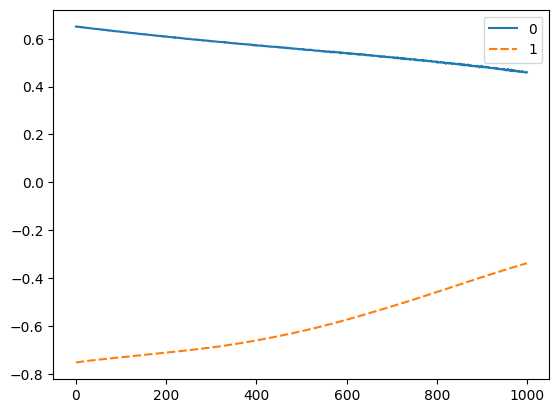

In [302]:
m = [5,arraylength] #batchsize
maxiter = 1000
gen_losses = []
dis_losses = []
tot_losses = []
for iter in tqdm(range(maxiter)):
    #loss = tot_loss(m)
    #tot_losses.append(loss.item())
    # discriminator update
    dis_opt.zero_grad()
    for k in range(1):
        loss = dis_loss(m)
        loss.backward()
        dis_opt.step()
    dis_losses.append(dis_lossR(m).item())
    #dis_losses.append(loss.item())
    # generator update
    gen_opt.zero_grad()
    loss = gen_loss(m)
    gen_losses.append(loss.item())
    loss.backward()
    dis_opt.step()
#sns.lineplot(data=[dis_losses,gen_losses,tot_losses])
sns.lineplot(data=[dis_losses,gen_losses])

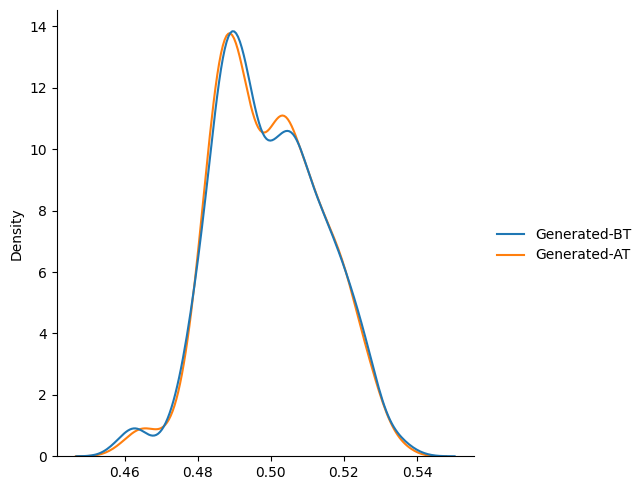

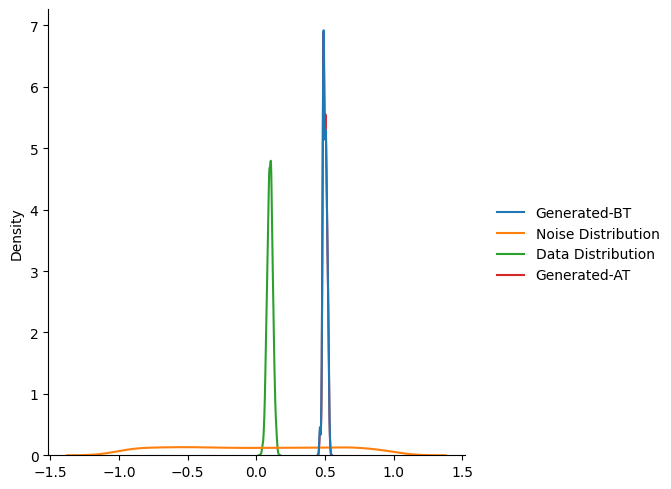

In [303]:
m=[20,arraylength]
z = torch.from_numpy(noisesample(m)).float().to(dev)
distribution_sims['Generated-AT'] = np.transpose(np.concatenate(Generator(z).data.tolist()))

sns.displot(data=distribution_sims[["Generated-BT","Generated-AT"]],kind="kde")
sns.displot(data=distribution_sims,kind="kde")

In [304]:
print(Discriminator(torch.from_numpy(data_distribution([10,arraylength])).float().to(dev)))
print(Discriminator(torch.from_numpy(noisesample([10,arraylength])).float().to(dev)))


tensor([[0.6312],
        [0.6297],
        [0.6330],
        [0.6340],
        [0.6290],
        [0.6304],
        [0.6297],
        [0.6285],
        [0.6294],
        [0.6322]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5755],
        [0.6269],
        [0.6156],
        [0.5685],
        [0.6627],
        [0.6323],
        [0.6289],
        [0.5836],
        [0.6204],
        [0.6220]], device='cuda:0', grad_fn=<SigmoidBackward0>)
